In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from data.data_import import (
    load_data, load_ecb_1y_yield,
    fill_liabilities, drop_high_leverage_firms,
    prepare_nig_inputs
)

from NIG_weekly.nig_apath import NIGParams, invert_assets_weekly_for_firm
from NIG_weekly.nig_em import fit_nig_params_from_weekly_assets
from NIG_weekly.nig_pd import pd_weekly_one_firm

In [ ]:
# data import and input panel preparation
ret_daily, bs, coverage = load_data(
    Path.cwd() / "data/raw/Jan2025_Accenture_Dataset_ErasmusCase.xlsx",
    start_date="2012-01-01",
    end_date="2025-12-19",
    enforce_coverage=True,
    coverage_tol=0.95,
    liabilities_scale="auto",
    verbose=True,
)

df_rf = load_ecb_1y_yield(
    startPeriod="2010-01-01",
    endPeriod="2025-12-31",
    out_file="data/raw/ecb_yc_1y_aaa.xml",
    verify_ssl=True,
)

df_cal = ret_daily[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)

debt_daily = fill_liabilities(bs, df_cal)

ret_filt, bs_filt, lev_by_firm, dropped = drop_high_leverage_firms(
    ret_daily,
    bs,
    df_calendar=df_cal,
    debt_daily=debt_daily,
    lev_threshold=8.0,
    lev_agg="median",
    verbose=True,
)

# keep debt panel consistent with filtered firms
keep = set(ret_filt["gvkey"].astype(str).unique())
debt_daily_filt = debt_daily[debt_daily["gvkey"].astype(str).isin(keep)].copy()

nig_df, em_cache = prepare_nig_inputs(ret_filt, bs_filt, df_rf, debt_daily=debt_daily_filt, build_em=False)
print(nig_df.head())
print(nig_df.shape)
print(nig_df.describe())

[load_data] Firms (ret_daily): 46
[load_data] Date range (ret_daily): 2012-01-03 .. 2025-12-19
[load_data] Coverage min/median/max: 0.999 / 1.000 / 1.000
[load_data] liabilities_scale_used: 1e+06
[load_data] QA mcap_reported<=0 rows (raw windowed mkt): 62
Data has been written to ecb_yc_1y_aaa.xml
[drop_high_leverage_firms] agg=median, threshold=8.0
[drop_high_leverage_firms] firms before: 46 | after: 36
[drop_high_leverage_firms] dropped firms: 10
    gvkey       date             E          isin  \
0  100022 2012-01-03  3.328431e+10  DE0005190003   
1  100080 2012-01-03  4.268705e+10  DE000BAY0017   
2  100312 2012-01-03  1.469717e+09  DE0007030009   
3  100581 2012-01-03  4.935351e+10  FR0000120321   
4  100957 2012-01-03  2.931851e+10  ES0144580Y14   

                        company country_iso         r             L  
0  BAYERISCHE MOTOREN WERKE AKT         DEU  0.001177  8.576700e+10  
1                      BAYER AG         DEU  0.001177  3.254300e+10  
2                RHEINME

In [25]:
# Global settings
P0 = NIGParams(alpha=15.0, beta=-3.0, delta=0.20, mu=0.00)
INVERT_U = 120.0
INVERT_N = 2000

WINDOW_WEEKS = 104
REFIT_EVERY = 13
HORIZON_WEEKS = 52.0

PD_START = pd.Timestamp("2014-01-01")   # burn-in satisfied by construction

# Identify firms
gvkeys = (
    nig_df["gvkey"]
    .astype(str)
    .dropna()
    .unique()
)
gvkeys = sorted(gvkeys)

print("n_firms:", len(gvkeys), "date span:", nig_df["date"].min(), "→", nig_df["date"].max())

n_firms: 36 date span: 2012-01-03 00:00:00 → 2025-12-19 00:00:00


In [26]:
# Storage
assets_by_firm = {}     # gvkey -> weekly assets df
updates_by_firm = {}    # gvkey -> quarterly updates df
pds_by_firm = {}        # gvkey -> weekly pd df

run_log = []            # per-firm timing + basic QC

t0_all = time.time()

for k, gv in enumerate(gvkeys, 1):
    t0 = time.time()

    g = nig_df.loc[nig_df["gvkey"].astype(str) == gv].sort_values("date").copy()
    if g.empty:
        continue

    # Step 1: weekly inversion
    try:
        assets_w = invert_assets_weekly_for_firm(g, P0, U=INVERT_U, n=INVERT_N)
    except Exception as e:
        run_log.append({"gvkey": gv, "status": "FAIL_INVERT", "err": str(e)})
        continue

    # basic QC
    nan_A = int(assets_w["A_hat"].isna().sum())
    n_weeks = int(len(assets_w))

    # Step 2: quarterly refit (on weekly dlogA, theta-aware)
    try:
        upd = fit_nig_params_from_weekly_assets(
            assets_w,
            p0=P0,
            window_weeks=WINDOW_WEEKS,
            refit_every=REFIT_EVERY,
            use_theta=True,
            prefer_precomputed_theta=True,  # you already have theta from inversion
            verbose=False,                  # switch True if debugging one firm
        )
    except Exception as e:
        run_log.append({"gvkey": gv, "status": "FAIL_EM", "err": str(e), "weeks": n_weeks, "nan_A": nan_A})
        continue

    # Step 3: weekly PD from 2014 onward
    try:
        assets_pd = assets_w.loc[assets_w["date"] >= PD_START].copy()
        pd_w = pd_weekly_one_firm(
            assets_pd,
            gvkey=str(gv),
            param_updates=upd,
            p0=P0,
            horizon_weeks=HORIZON_WEEKS,
        )
    except Exception as e:
        run_log.append({"gvkey": gv, "status": "FAIL_PD", "err": str(e), "weeks": n_weeks, "nan_A": nan_A})
        continue

    # store
    assets_by_firm[gv]  = assets_w.assign(gvkey=str(gv))
    updates_by_firm[gv] = upd.assign(gvkey=str(gv))
    pds_by_firm[gv]     = pd_w.assign(gvkey=str(gv))

    # quick PD QC
    pd_nan = float(pd_w["PD_1y"].isna().mean())
    pd_min = float(pd_w["PD_1y"].min())
    pd_max = float(pd_w["PD_1y"].max())

    run_log.append({
        "gvkey": gv,
        "status": "OK",
        "weeks": n_weeks,
        "nan_A": nan_A,
        "n_updates": int(len(upd)),
        "pd_rows": int(len(pd_w)),
        "pd_nan_share": pd_nan,
        "pd_min": pd_min,
        "pd_max": pd_max,
        "sec": time.time() - t0,
    })

    if (k % 10) == 0:
        ok_count = sum(r["status"] == "OK" for r in run_log)
        print(f"[{k}/{len(gvkeys)}] last gv={gv} | OK={ok_count} | last_sec={run_log[-1].get('sec',np.nan):.2f}")

print("Total runtime (sec):", time.time() - t0_all)

[10/36] last gv=101336 | OK=10 | last_sec=3.05
[20/36] last gv=201794 | OK=20 | last_sec=4.66
[30/36] last gv=241456 | OK=30 | last_sec=3.72
Total runtime (sec): 140.51948142051697


In [27]:
assets_weekly_all = pd.concat(assets_by_firm.values(), ignore_index=True)
updates_all = pd.concat(
    [df.assign(gvkey=str(gv)) for gv, df in updates_by_firm.items()],
    ignore_index=True
)
pds_weekly_all = pd.concat(pds_by_firm.values(), ignore_index=True)

log_df = pd.DataFrame(run_log).sort_values(["status", "sec"], ascending=[True, False])

print("assets_weekly_all:", assets_weekly_all.shape)
print("updates_all:", updates_all.shape)
print("pds_weekly_all:", pds_weekly_all.shape)
log_df["status"].value_counts()

assets_weekly_all: (26244, 9)
updates_all: (1764, 13)
pds_weekly_all: (22500, 9)


status
OK    36
Name: count, dtype: int64

In [28]:
print(pds_weekly_all.keys())
print(updates_all.keys())
print(assets_weekly_all.keys())


Index(['gvkey', 'date', 'A_hat', 'L', 'alpha', 'beta', 'delta', 'mu', 'PD_1y'], dtype='object')
Index(['date', 'alpha', 'beta', 'delta', 'mu', 'emp_mean', 'mod_mean',
       'emp_std', 'mod_std', 'alpha_required_from_theta', 'alpha_hits_floor',
       'window_len', 'gvkey'],
      dtype='object')
Index(['date', 'E', 'L', 'r', 'A_hat', 'theta', 'logA', 'dlogA', 'gvkey'], dtype='object')


In [29]:
pds_weekly_all["PD_1y"].between(0,1).all(), pds_weekly_all["PD_1y"].isna().mean()
pds_weekly_all["PD_1y"].describe(percentiles=[0.5,0.9,0.95,0.99,0.995,0.999])

count    2.250000e+04
mean     8.299354e-03
std      4.140183e-02
min      1.028639e-20
50%      5.759388e-04
90%      1.059960e-02
95%      2.612594e-02
99%      1.605698e-01
99.5%    2.713382e-01
99.9%    5.808910e-01
max      6.250284e-01
Name: PD_1y, dtype: float64

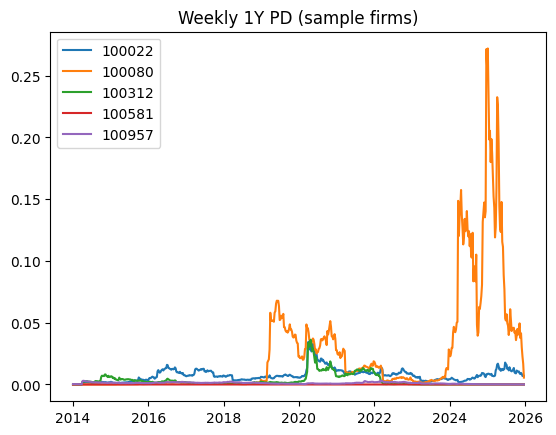

In [30]:
import matplotlib.pyplot as plt

sample_gv = list(pds_by_firm.keys())[:5]
plt.figure()
for gv in sample_gv:
    d = pds_by_firm[gv]
    plt.plot(d["date"], d["PD_1y"], label=gv)
plt.title("Weekly 1Y PD (sample firms)")
plt.legend()
plt.show()

In [31]:
top = (pds_weekly_all
       .sort_values("PD_1y", ascending=False)
       .head(30))
top

,gvkey,date,A_hat,L,alpha,beta,delta,mu,PD_1y
19415,243774,2014-10-10,1.961484e+11,1.860419e+11,3.617073,-0.000074,0.000594,-0.001239,0.625028
19416,243774,2014-10-17,1.962101e+11,1.860419e+11,3.617073,-0.000074,0.000594,-0.001239,0.621900
19414,243774,2014-10-03,1.962360e+11,1.860419e+11,3.617073,-0.000074,0.000594,-0.001239,0.620582
19417,243774,2014-10-24,1.963868e+11,1.860419e+11,3.617073,-0.000074,0.000594,-0.001239,0.612833
19546,243774,2017-04-14,1.769254e+11,1.592203e+11,3.321808,-0.000076,0.001252,-0.002412,0.611501
19547,243774,2017-04-21,1.770335e+11,1.592203e+11,3.321808,-0.000076,0.001252,-0.002412,0.608286
19544,243774,2017-03-31,1.770413e+11,1.592203e+11,3.321808,-0.000076,0.001252,-0.002412,0.608053
19406,243774,2014-08-08,1.962036e+11,1.860419e+11,3.617028,-0.000119,0.000594,-0.001200,0.601297
19407,243774,2014-08-15,1.962781e+11,1.860419e+11,3.617028,-0.000119,0.000594,-0.001200,0.597345
19545,243774,2017-04-07,1.774019e+11,1.592203e+11,3.321808,-0.000076,0.001252,-0.002412,0.597221


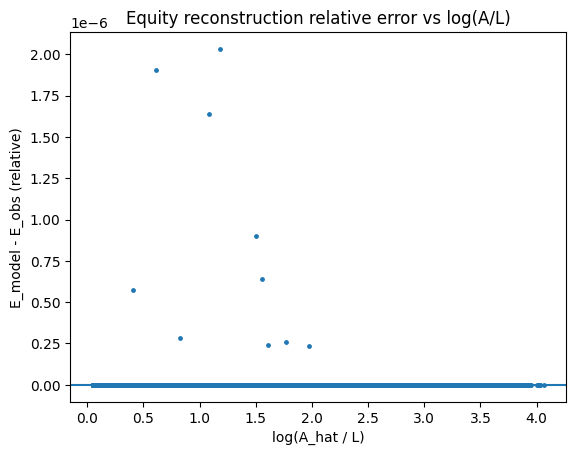

count    2.250000e+04
mean     3.868999e-10
std      2.333402e-08
min      0.000000e+00
50%      0.000000e+00
90%      2.009382e-16
95%      2.364414e-16
99%      3.786230e-16
99.9%    8.540231e-16
max      2.033651e-06
Name: E_rel_err, dtype: float64
share |rel_err| > 5e-4: 0.0


,gvkey,n,share_|z|>thr,max_|ret|,top1pct_energy_share
31,243774,728,0.019231,0.367112,0.873859
19,201794,728,0.004121,0.202976,0.565560
27,23667,728,0.004121,0.320364,0.561032
25,221616,728,0.002747,0.297748,0.599460
28,23671,728,0.002747,0.304641,0.397764
35,61616,728,0.002747,0.169264,0.369863
33,24625,728,0.002747,0.154953,0.357276
1,100080,728,0.001374,0.377363,0.458925
30,241637,728,0.001374,0.312660,0.443098
17,17828,728,0.001374,0.120699,0.393950


,date,dlogA,robust_z,abs_ret
535,2012-04-13,0.367112,132.536171,0.367112
19219,2022-03-25,0.329143,118.815466,0.329143
15439,2020-03-20,-0.177988,-64.445487,0.177988
11695,2018-03-23,-0.175847,-63.672048,0.175847
7915,2016-03-18,-0.173163,-62.702149,0.173163
21091,2023-03-24,0.171486,61.843128,0.171486
13567,2019-03-22,0.157939,56.947627,0.157939
4171,2014-03-21,-0.129716,-47.001654,0.129716
6043,2015-03-20,0.124119,44.726121,0.124119
22963,2024-03-22,-0.114683,-41.569238,0.114683


median refit / nonrefit abs logit jump ratio: 1.289336390742495
refit abs dlogit summary:
 count    5182.000000
mean        0.203755
std         0.588168
min         0.000000
50%         0.081994
90%         0.421423
95%         0.657547
99%         1.633620
max        11.071120
Name: dlogit_pd, dtype: float64
non-refit abs dlogit summary:
 count    1.095554e+06
mean     1.159727e-01
std      3.012856e-01
min      0.000000e+00
50%      6.359368e-02
90%      2.338537e-01
95%      3.457286e-01
99%      8.011672e-01
max      1.107112e+01
Name: dlogit_pd, dtype: float64


,gvkey,date,PD_1y,pd_prev,dlogit_pd,is_refit_week,refit_date,refit_dist_days
153762,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2014-01-03,91
153763,101202,2014-04-04,0.000064,9.789571e-10,11.07112,True,2014-04-04,0
153764,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2014-07-04,91
153765,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2014-10-03,182
153766,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2015-01-02,273
153767,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2015-04-03,364
153768,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2015-07-03,455
153769,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2015-10-02,546
153770,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2016-01-01,637
153771,101202,2014-04-04,0.000064,9.789571e-10,11.07112,False,2016-04-01,728


In [33]:
from nig_safety import (
    check_equity_reconstruction_errors,
    check_asset_return_outliers,
    check_refit_date_jumps,
    compare_two_pd_panels,
)

assets_weekly_all = assets_weekly_all.copy()
updates_all = updates_all.copy()

assets_weekly_all["date"] = pd.to_datetime(assets_weekly_all["date"])
updates_all["date"] = pd.to_datetime(updates_all["date"])
assets_weekly_all["gvkey"] = assets_weekly_all["gvkey"].astype(str)
updates_all["gvkey"] = updates_all["gvkey"].astype(str)

# drop bad dates (merge_asof restrictions)
assets_weekly_all = assets_weekly_all.dropna(subset=["date", "gvkey"])
updates_all = updates_all.dropna(subset=["date", "gvkey"])
assets_weekly_all = assets_weekly_all.sort_values(["date", "gvkey"]).reset_index(drop=True)
updates_all = updates_all.sort_values(["date", "gvkey"]).reset_index(drop=True)

assets_weekly_with_params = pd.merge_asof(
    assets_weekly_all,
    updates_all[["gvkey", "date", "alpha", "beta", "delta", "mu"]],
    on="date",
    by="gvkey",
    direction="backward",
    allow_exact_matches=True,
)

# resrict to rows where we have all parameters
assets_weekly_with_params = assets_weekly_with_params.loc[
    assets_weekly_with_params["alpha"].notna()
].copy()

# (i) Equity reconstruction errors
eq = check_equity_reconstruction_errors(
    assets_weekly_with_params,
    tau_inv=1.0,
    use_theta_col="theta",
    max_abs_rel_err_warn=5e-4,
    plot=True,
)
print(eq["summary_abs_rel_error"])
print("share |rel_err| > 5e-4:", eq["share_abs_rel_err_gt_thresh"])

# (ii) Return outliers (dlogA)
tails = check_asset_return_outliers(
    assets_weekly_all,
    ret_col="dlogA",
    z_thresh=10.0,
    topk=10,
)
display(tails["worst_firms"])
# inspect one flagged firm
bad_gv = tails["worst_firms"].iloc[0]["gvkey"]
ex = [r for r in tails["per_firm"] if r["gvkey"] == bad_gv][0]["examples_top_outliers"]
display(ex)

# (iii) Jumps at refit dates (PD discontinuities)
jumps = check_refit_date_jumps(
    pds_weekly_all,
    updates_all,
    pd_col="PD_1y",
    refit_merge_tol_days=7,
)
print("median refit / nonrefit abs logit jump ratio:", jumps["ratio_median_refit_to_nonrefit"])
print("refit abs dlogit summary:\n", jumps["abs_dlogit_pd_refit_desc"])
print("non-refit abs dlogit summary:\n", jumps["abs_dlogit_pd_nonrefit_desc"])
display(jumps["top_abs_jumps"])

In [ ]:
# save final_df as CSV in the current working directory
pds_weekly_all.to_csv("data/derived/NIG_weekly.csv", index=False)